In [1]:
# Run deze cel alleen één keer om alle libraries te installeren
#!pip install pandas torch torchvision pytorch-lightning torchmetrics matplotlib

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



# 🏋️‍♀️Fitness identifier Eerste iteratie 

<h2 style="font-size:20px; color:#3B82F6;">Inleiding</h2>

In dit notebook ga ik voor het eerst experimenteren met image classification voor mijn AI-fitnessapp. In de eerste fase van dit project heb ik samen met mijn docent, Bas Michielsen, een geschikte aanpak geformuleerd voor mijn Personal Project.
Bas raadde mij aan om zijn Clothing Classifier-project te gebruiken als eerste testbasis.
Aan de hand van deze test wil ik, samen met hem, verder onderzoeken welke onderdelen ik kan hergebruiken en wat ik eventueel moet aanpassen voor mijn eigen project. In dit notebook documenteer ik mijn eerste test, inclusief opzet, resultaten en reflectie

Voor mijn afbeeldingen ga ik een mix gebruiken uit bestaande datasets en zelfgemaakte afbeeldingen

<h2 style="font-size:20px; color:#3B82F6;">Imports</h2>



Ik heb de categorien van Bas zijn repo veranderd naar categorien voor mijn eigen project

![alt-tekst](images/mappenstructuurFitnessapp.png)

In [2]:
import pandas, platform, os
import torch as T 
import torchvision as V
import pytorch_lightning as L
import torch.utils.data as D
import torchmetrics as M
import matplotlib.pyplot as plt




data_path = "dataset/data"
inference_path = "dataset/inference"

T.manual_seed(42)

print("Versions: python", platform.python_version(), "| torch", T.__version__, "| torchvision", V.__version__, "| pytorch_lightning", L.__version__)


Versions: python 3.13.7 | torch 2.9.0+cpu | torchvision 0.24.0+cpu | pytorch_lightning 2.5.5


<h2 style="font-size:20px; color:#3B82F6;">Controle van datasetbalans</h2>

Ik controleer het aantal afbeeldingen per oefening om te zien of mijn dataset goed in balans is.
Wanneer sommige mappen veel meer foto’s bevatten dan andere, kan het AI-model scheef leren en bepaalde oefeningen beter herkennen.
Door dit te controleren weet ik zeker dat alle categorieën evenredig zijn vertegenwoordigd en de dataset klaar is voor training.

In [3]:
import os

data_path = r"C:\Users\yusuf\OneDrive\Documenten\HBO ICT\AlleGit - Github\fitness-exercise-identifier\reference\classification_image--clothing\dataset\data"

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{folder}: {count} foto's")


cable_flyes: 200 foto's
incline_benchpress: 143 foto's
machine_pulldown: 210 foto's
pullup: 270 foto's
romanian_deadlift: 280 foto's
squats: 336 foto's


<h2 style="font-size:20px; color:#3B82F6;">pre-trained model inladen</h2>

In [4]:
pretrained_model = V.models.resnet18(weights="DEFAULT")

<h2 style="font-size:20px; color:#3B82F6;">dataset voorbereiden</h2>

In [5]:
image_size = (244, 244)

transform = V.transforms.Compose([
    V.transforms.Resize(image_size),
    V.transforms.ToTensor(),
])

dataset = V.datasets.ImageFolder(data_path, transform=transform)
classes = dataset.classes
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['cable_flyes', 'incline_benchpress', 'machine_pulldown', 'pullup', 'romanian_deadlift', 'squats']


<h2 style="font-size:20px; color:#3B82F6;">Steekproef van de date</h2>

Dit is slechts een willekeurige steekproef van afbeeldingen en hun labels.

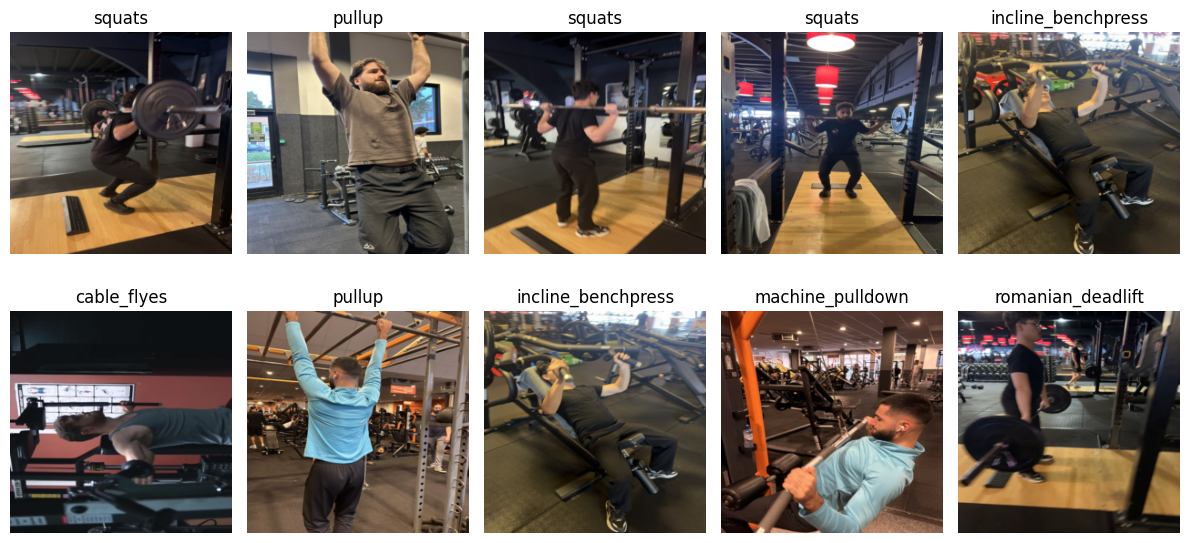

In [6]:
import torch as T
import matplotlib.pyplot as plt
import numpy as np

sample_size = 10
indices = T.randperm(len(dataset))[:sample_size]
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]

fig, axes = plt.subplots(nrows=int(sample_size / 5), ncols=5, figsize=(12, 6))

for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
    ax = axes[i // 5, i % 5]
    # Transponeer dimensies zodat afbeelding juist georiënteerd wordt weergegeven
    ax.imshow(image.permute(2, 1, 0).numpy())
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()


<h2 style="font-size:20px; color:#3B82F6;">Maak een datamodule</h2>

Hier breiden we de LightningDataModule uit om een DataModule te maken die de dataset opsplitst in train, validatie en test-data, en specifieke loaders aanmaakt die we later nodig hebben.

In [7]:
class DataModule(L.LightningDataModule):
    def __init__(self, data, split=[.7, .2, .1], batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.data = data
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train, self.val, self.test = D.random_split(self.data, self.split)

    def train_dataloader(self):
        return D.DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return D.DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return D.DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)


datamodule = DataModule(dataset)
datamodule.setup()

<h2 style="font-size:20px; color:#3B82F6;">Maak een image classifier model</h2>



In [8]:
class ImageClassifierModel(L.LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = T.nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = T.nn.CrossEntropyLoss()
        self.accuracy = M.Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = M.Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = M.Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return T.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        self.log("val_loss", self.criterion(logits, y))

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])


model = ImageClassifierModel(pretrained_model, num_classes=len(classes))

<h2 style="font-size:20px; color:#3B82F6;">Trainen</h2>



In [ ]:
logger = L.loggers.CSVLogger(save_dir=".")
stop = L.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min")
trainer = L.Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(model, datamodule=datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
3.1 K     Trainable params
11.2 M   

MisconfigurationException: `train_dataloader` must be implemented to be used with the Lightning Trainer